In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets

# Run the following before any XLA modules such as JAX:
import chex

chex.set_n_cpu_devices(2)

# Import the remaining JAX related
from mubelnet.mcmc import sample_markov_chain
from mubelnet.nets import MultinomialBelief

import haiku as hk
import jax

2024-03-26 11:53:46.795968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 11:53:46.795998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 11:53:46.797030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 11:53:48.926227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


To illustrate how to use the multinomial belief network, we will train the
model on the UCI ML datasets, containing handwritten digits.

The dataset can directly be loaded from scikit-learn. As preprocessing step, we reshape the
digits from a 8x8 square matrix to a flat array of size 64.

In [2]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X_train = digits.images.reshape((n_samples, -1))

This is what a typical image looks like:

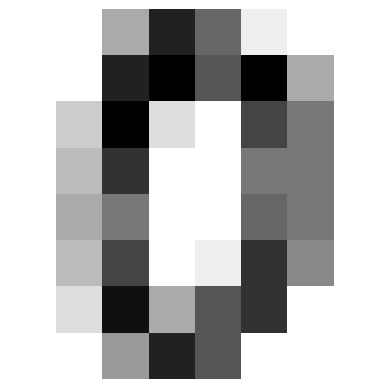

In [3]:
plt.imshow(X_train[0].reshape(8, 8), cmap=plt.cm.gray_r, interpolation="nearest")
plt.gca().set_axis_off()

Next, we define the model. We use a simple decoder network with two hidden layers. In
total, the size of the network: 2 x 10 x 64.

```
hidden_units = (2, 10)
model = MultinomialBelief(hidden_units, n_features)
```

This function has to be defined in a [haiku](https://github.com/deepmind/dm-haiku) context to transform the network in a pure state for JAX.

Since the network is a Bayesian model, we don't train the model by
minimising a loss. Rather, we infer the distribution $p(\boldsymbol{\theta}|\boldsymbol{X}_{\mathrm{train}})$ of the model's parameters $\boldsymbol{\theta}$ given the training data $\boldsymbol{X}_{\mathrm{train}}$ that we observe. This probability distribution is called the [posterior](https://en.wikipedia.org/wiki/Posterior_probability).

Unfortunately, we don't know what this distribution is. However, we do know a way how to sample it: using Markov chain Monte Carlo (MCMC). This simulation method samples the distributions by taking small steps that depend on its previous state. In theory, when we have take enough steps, the state converges to the true (posterior) distribution.

To take one step, you simply call your model using
the training data:

```python
model(X_train)
```

This function call does one Gibbs sampling step, which updates all the parameters one-by-one. The initialisation of the chain  (which are initialised with ancesetral samples) is automatically taken care for you.

Now, lets put all elements together.

In [4]:
# Pseudo-random number generator sequence.
key_seq = hk.PRNGSequence(42)

m_samples, n_features = X_train.shape

@hk.transform_with_state
def kernel():
    """Advance the Markov chain by one step."""
    hidden_units = (2, 10)
    model = MultinomialBelief(hidden_units, n_features)
    model(X_train)  # Do one Gibbs step.

Here, we defined a function that proposes a new state based on its current configuration. This is called a _kernel_. The `hk.transform_with_state` decorator uses haiku to purify the function into something that is stateless.

Finally, we draw samples from the Markov chain. We first take 100 burn-in steps, in the
hope that the chain converges to the true distribution. After throwing away these first 100 samples, we collect a new set
of 50 samples (25 in each chain) to estimate the posterior distribution.

Note that `sample_markov_chain` (below) automatically takes care of distributing your
computation across multiple devices. For simplicity, we assume you are running on a CPU and split the CPU up in two virtual devices. (See above, at the import section, where we've used
`chex` set the number of devices to 2.)

The following cell, that collects statistics from the Markov chain takes, about `10 minutes` to run on a CPU.

In [5]:
n_chains = jax.device_count()

params, trace = sample_markov_chain(
    next(key_seq),
    kernel=kernel,
    n_samples=50,
    n_burnin_steps=100,
    n_chains=n_chains,
)

_ = trace['multinomial_belief/~/multinomial_layer']['phi'].block_until_ready()

/home/hylke/.local/lib/python3.11/site-packages/mubelnet/random.py:326: UserWarning: Explicitly requested dtype float64 requested in zeros_like is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x_jk = jnp.zeros_like(b.transpose(), dtype=x.dtype)
/home/hylke/.local/lib/python3.11/site-packages/mubelnet/random.py:344: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x_pad = jnp.zeros((n_pad, x.shape[1]), x.dtype)
/home/hylke/.local/lib/python3.11/site-packages/mubelnet/random.py:326: UserWarning: Explicitly requested dtype float64 requested in zeros_like

After training the model, we can inspect what the model has learned. Note that, instead of a single point estimate of the parameters, we've obtained a distribution. To visualise the parameters, we take for simplicity the median. Let's take a look at $\bm{\Phi}^{(1)}$, the weights of the first layer.

<Figure size 640x480 with 0 Axes>

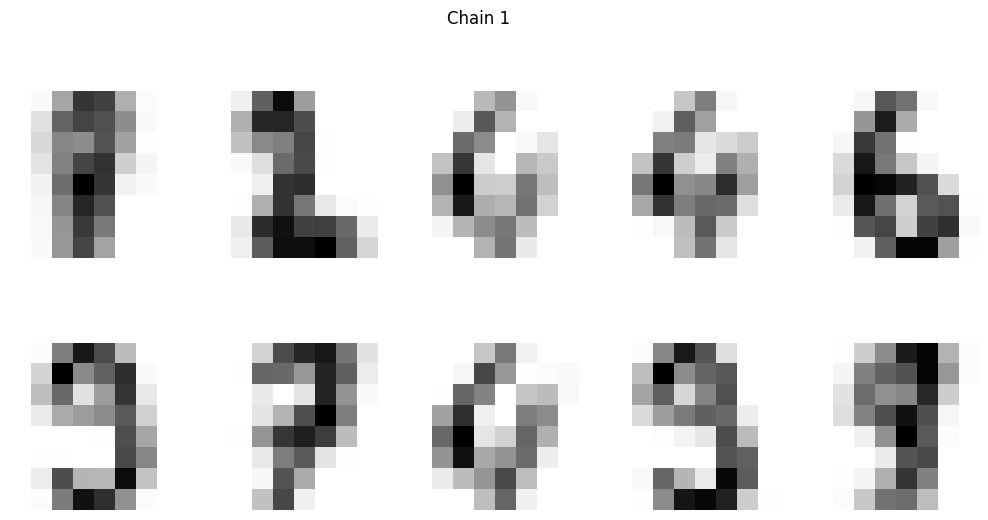

<Figure size 640x480 with 0 Axes>

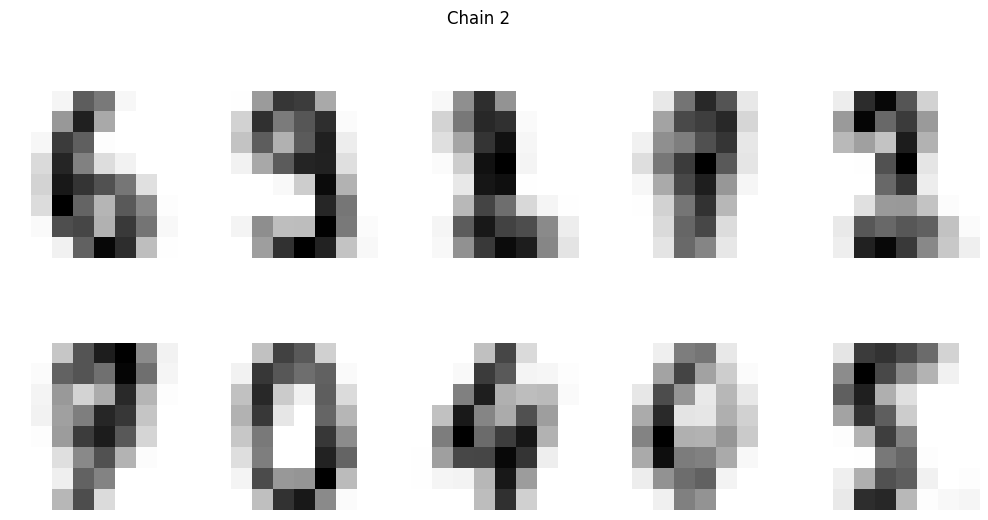

In [6]:
# Aggregate posterior samples to visualise.
phi_1st_layer = np.mean(trace['multinomial_belief/~/multinomial_layer']['phi'], axis=[1])

for i in range(n_chains):  # For each Markov chain.
    plt.figure()
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(12.5, 6))
    plt.suptitle(f'Chain {i+1}')
    # Plot the weights of all 10 hidden states.
    for ax, phi in zip(axes.flatten(), phi_1st_layer[i]):
        ax.set_axis_off()
        image = phi.reshape(8, 8)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")